# Boxplots for permutations analysis (male downsampling to female level)

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Function and configuration

In [2]:
save_ggplots <- function(p, fn, w=6, h=6){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}

In [3]:
config = list(
    "Caudate"="../../../caudate/subsampling_male/deg_summary/_m/permutations.csv", 
    "DLPFC"="../../../dlpfc/subsampling_male/deg_summary/_m/permutations.csv", 
    "Hippocampus"="../../../hippocampus/subsampling_male/deg_summary/_m/permutations.csv"
)

## Merge dataframes

In [4]:
datalist = list()
for(tissue in c("Caudate", "DLPFC", "Hippocampus")){
    df = data.table::fread(config[[tissue]])
    df$tissue <- tissue  # maybe you want to keep track of which iteration produced it?
    datalist[[tissue]] <- df
}
big_df <- bind_rows(datalist) %>% 
    select(Symbol, gencodeID, logFC, t, adj.P.Val, Permutation, tissue)
big_df %>% head()

Symbol,gencodeID,logFC,t,adj.P.Val,Permutation,tissue
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
GDNF-AS1,ENSG00000248587.7,1.0167229,9.197466,4.897059e-11,2,Caudate
KCNH5,ENSG00000140015.19,0.5280977,6.149131,1.056831e-04,2,Caudate
GDNF,ENSG00000168621.14,0.7521216,6.069025,1.056831e-04,2,Caudate
RMDN2,ENSG00000115841.19,-0.3113023,-6.039298,1.056831e-04,2,Caudate
PAPPA,ENSG00000182752.9,0.7205277,6.009417,1.056831e-04,2,Caudate
KLF10,ENSG00000155090.14,0.6370241,5.893526,1.510394e-04,2,Caudate


`summarise()` has grouped output by 'Permutation'. You can override using the `.groups` argument.



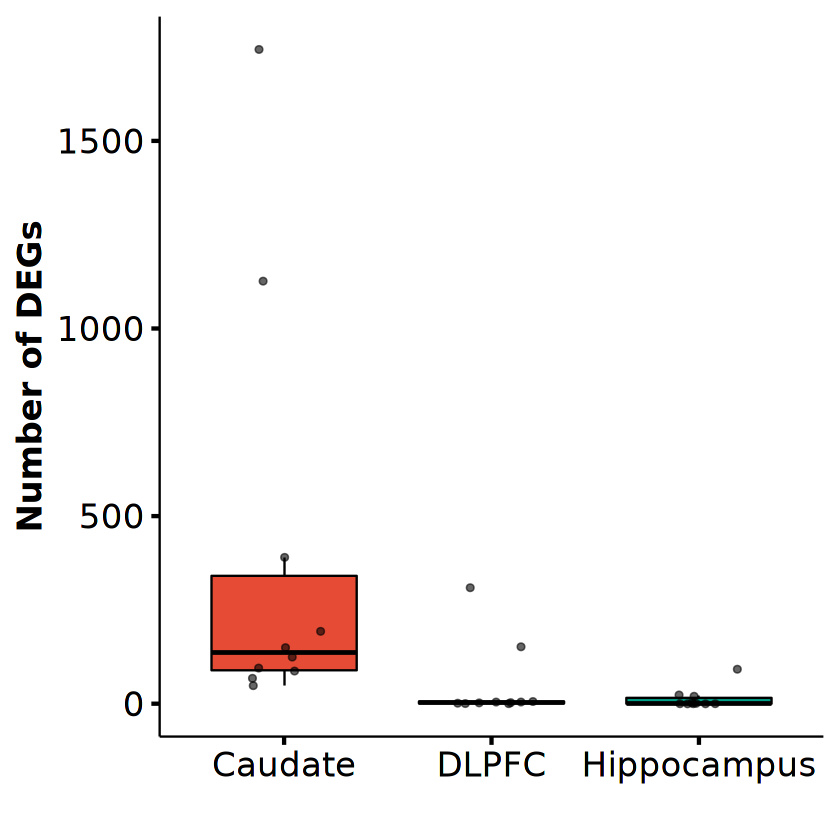

In [5]:
bxp = big_df %>% group_by(Permutation, tissue) %>% summarize(Size = n()) %>%
    as.data.frame %>% pivot_wider(names_from = tissue, values_from = Size) %>%
    replace_na(list(DLPFC = 0, Hippocampus = 0)) %>% 
    pivot_longer(-Permutation, names_to="Tissue", values_to="DEGs") %>%
    mutate_if(is.character, as.factor) %>%
    ggboxplot(x="Tissue", y="DEGs", fill="Tissue", add="jitter", 
              xlab='', palette="npg", ylab="Number of DEGs", 
              add.params=list(alpha=0.6), outlier.shape=NA,
              panel.labs.font=list(face='bold'), legend="", 
              ggtheme=theme_pubr(base_size=20))+ 
        font("xy.title", face="bold")
save_ggplots(bxp, "permutation_boxplots_3regions", 6, 5)
bxp

`summarise()` has grouped output by 'Permutation'. You can override using the `.groups` argument.



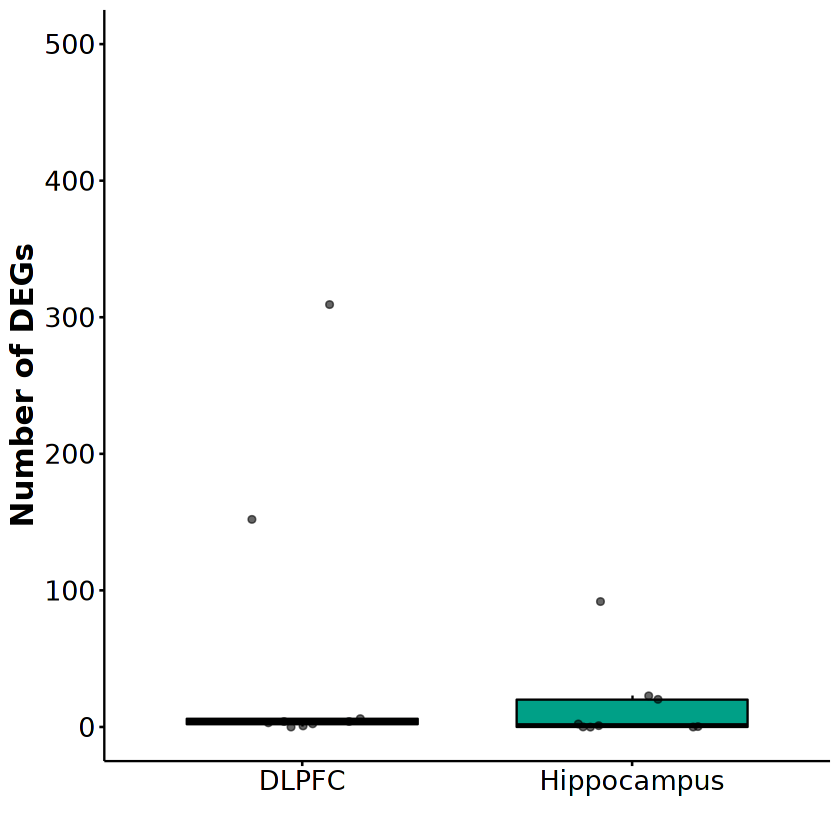

In [6]:
bxp = big_df %>% filter(tissue != "Caudate") %>%
    group_by(Permutation, tissue) %>% summarize(Size = n()) %>%
    as.data.frame %>% pivot_wider(names_from = tissue, values_from = Size) %>%
    replace_na(list(DLPFC = 0, Hippocampus = 0)) %>% 
    pivot_longer(-Permutation, names_to="Tissue", values_to="DEGs") %>%
    mutate_if(is.character, as.factor) %>%
    ggboxplot(x="Tissue", y="DEGs", fill="Tissue", add="jitter", 
              xlab='', palette=get_palette("npg", 3)[2:3], ylab="Number of DEGs", 
              add.params=list(alpha=0.6), outlier.shape=NA,
              panel.labs.font=list(face='bold', size = 18), 
              legend="", ylim=c(0, 500))+ 
        font("xy.title", size=18, face="bold") + 
        font("xy.text", size=16)
save_ggplots(bxp, "permutation_boxplots_2regions", 6, 5)
bxp

In [7]:
big_df %>% group_by(Permutation, tissue) %>% summarize(Size = n()) %>%
    as.data.frame %>% pivot_wider(names_from = tissue, values_from = Size) %>%
    replace_na(list(DLPFC = 0, Hippocampus = 0)) %>% 
    pivot_longer(-Permutation, names_to="Tissue", values_to="DEGs") %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Tissue) %>% summarize(Mean = mean(DEGs), Median = median(DEGs), Std = sd(DEGs))

`summarise()` has grouped output by 'Permutation'. You can override using the `.groups` argument.



Tissue,Mean,Median,Std
<fct>,<dbl>,<dbl>,<dbl>
Caudate,402.4,136.5,571.60616
DLPFC,48.1,3.5,103.02691
Hippocampus,13.8,0.5,28.85519


## Reproducibility Information

In [8]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-08-06 10:56:08 EDT"

   user  system elapsed 
  4.986   0.258   5.558 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-08-06                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 